#### testing same setup as VAE but using AE

In [1]:
import time
import os

import scanpy
import numpy as np
import scipy.sparse as sp

import torch
from torch import optim
from torch.utils.data import DataLoader

import models.loadImg as loadImg
import models.modelsCNN as modelsCNN
import models.optimizer as optimizer

import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import gc
from skimage import io


In [2]:
os.environ["CUDA_LAUNCH_BLOCKING"] = "1" 
os.environ["CUDA_VISIBLE_DEVICES"] = "1" 

In [3]:
radius=48
datadir='/media/xinyi/dcis2idc1/data'
sampleList=[]
for s in os.listdir('/media/xinyi/dcis2idc1/data'):
    if 'hoechst'  in s and ('_1_' in s or '_3_' in s or '_4_' in s or '_6_' in s):
#     if 'hoechst'  in s and ('_3_' in s or '_4_' in s or '_6_' in s):
        sampleList.append(s)
print(sampleList)
trainingCores={'br1003a':[],'br8018a':[],'br301':[]}
for s in range(1,11):
# for s in range(5,11):
    trainingCores['br1003a'].append('A'+str(s))
    trainingCores['br1003a'].append('C'+str(s))
    trainingCores['br1003a'].append('I'+str(s))
for s in range(1,11):
    if s<9:
        trainingCores['br8018a'].append('H'+str(s))
    trainingCores['br8018a'].append('A'+str(s))
    trainingCores['br8018a'].append('B'+str(s))
    trainingCores['br8018a'].append('F'+str(s))
for s in range(1,7):
    for sr in ['A','B','C','D','E']:
        trainingCores['br301'].append(sr+str(s))

['br1003a_1_cytokeratin_555_aSMA_647_hoechst', 'br1003a_3_collagen1_647_hoechst', 'br1003a_4_cytokeratin_555_gh2ax_647_hoechst', 'br301_4_cytokeratin_555_aSMA_647_hoechst', 'br301_6_collagen1_647_hoechst', 'br8018a_1_cytokeratin_555_aSMA_647_hoechst', 'br8018a_3_collagen1_647_hoechst', 'br8018a_4_cytokeratin_555_gh2ax_647_hoechst']


In [4]:
trainingCores

{'br1003a': ['A1',
  'C1',
  'I1',
  'A2',
  'C2',
  'I2',
  'A3',
  'C3',
  'I3',
  'A4',
  'C4',
  'I4',
  'A5',
  'C5',
  'I5',
  'A6',
  'C6',
  'I6',
  'A7',
  'C7',
  'I7',
  'A8',
  'C8',
  'I8',
  'A9',
  'C9',
  'I9',
  'A10',
  'C10',
  'I10'],
 'br8018a': ['H1',
  'A1',
  'B1',
  'F1',
  'H2',
  'A2',
  'B2',
  'F2',
  'H3',
  'A3',
  'B3',
  'F3',
  'H4',
  'A4',
  'B4',
  'F4',
  'H5',
  'A5',
  'B5',
  'F5',
  'H6',
  'A6',
  'B6',
  'F6',
  'H7',
  'A7',
  'B7',
  'F7',
  'H8',
  'A8',
  'B8',
  'F8',
  'A9',
  'B9',
  'F9',
  'A10',
  'B10',
  'F10'],
 'br301': ['A1',
  'B1',
  'C1',
  'D1',
  'E1',
  'A2',
  'B2',
  'C2',
  'D2',
  'E2',
  'A3',
  'B3',
  'C3',
  'D3',
  'E3',
  'A4',
  'B4',
  'C4',
  'D4',
  'E4',
  'A5',
  'B5',
  'C5',
  'D5',
  'E5',
  'A6',
  'B6',
  'C6',
  'D6',
  'E6']}

In [3]:
allImg=loadImg.loadImg(datadir,sampleList,trainingCores,'segmented_nucleus','zproject/dna',radius,minmax=True)

['br1003a_1_cytokeratin_555_aSMA_647_hoechst', 'br1003a_3_collagen1_647_hoechst', 'br1003a_4_cytokeratin_555_gh2ax_647_hoechst', 'br301_4_cytokeratin_555_aSMA_647_hoechst', 'br301_6_collagen1_647_hoechst', 'br8018a_1_cytokeratin_555_aSMA_647_hoechst', 'br8018a_3_collagen1_647_hoechst', 'br8018a_4_cytokeratin_555_gh2ax_647_hoechst']
br1003a_1_cytokeratin_555_aSMA_647_hoechst
A1
C1
I1
A2
C2
I2
C3
I3
A4
C4
A5
C5
A6
C6
A7
C7
I7
A8
C8
I8
A9
C9
I9
C10
I10
br1003a_3_collagen1_647_hoechst
A1
C1
I1
A2
C2
I2
A3
C3
I3
C4
A5
C5
A6
C6
A7
C7
I7
A8
C8
I8
A9
C9
I9
C10
I10
br1003a_4_cytokeratin_555_gh2ax_647_hoechst
A1
C1
I1
A2
C2
I2
A3
I3
A4
C4
A5
C5
A6
C6
A7
C7
I7
A8
C8
I8
A9
C9
I9
A10
C10
br301_4_cytokeratin_555_aSMA_647_hoechst
A1
B1
C1
D1
E1
A2
B2
C2
D2
E2
A3
B3
C3
D3
E3
A4
B4
C4
D4
E4
A5
B5
C5
D5
E5
A6
B6
C6
D6
E6
br301_6_collagen1_647_hoechst
A1
B1
C1
D1
E1
A2
B2
C2
D2
E2
A3
B3
C3
D3
E3
A4
B4
C4
D4
E4
A5
B5
C5
D5
E5
A6
B6
C6
D6
E6
br8018a_1_cytokeratin_555_aSMA_647_hoechst
H1
A1
B1
F1
H2
A2
B2
F

In [18]:
sampleList_add=['br8018a_4_cytokeratin_555_gh2ax_647_hoechst']
trainingCores_add={'br8018a':['H2','H4','H7']}

In [8]:
addImg=loadImg.loadImg(datadir,sampleList_add,trainingCores_add,'segmented_nucleus','zproject/dna',radius,minmax=True)

br8018a_4_cytokeratin_555_gh2ax_647_hoechst
H2
H4
H7


In [9]:
allImg=np.concatenate((allImg,addImg),axis=0)

In [10]:
allImg.shape

(1876734, 1, 96, 96)

In [11]:
with open(os.path.join(datadir,'processed','train_cnnvae'), 'wb') as output:
    pickle.dump(allImg, output, pickle.HIGHEST_PROTOCOL)

In [12]:
#train-test split
np.random.seed(3)
pctVal=0.05
pctTest=0.1
allIdx=np.arange(allImg.shape[0])
np.random.shuffle(allIdx)
valIdx=allIdx[:int(pctVal*allImg.shape[0])]
testIdx=allIdx[int(pctVal*allImg.shape[0]):(int(pctVal*allImg.shape[0])+int(pctTest*allImg.shape[0]))]
trainIdx=allIdx[(int(pctVal*allImg.shape[0])+int(pctTest*allImg.shape[0])):]

In [13]:
with open(os.path.join(datadir,'processed','train_cnnvae_trainIdx'), 'wb') as output:
    pickle.dump(trainIdx, output, pickle.HIGHEST_PROTOCOL)
with open(os.path.join(datadir,'processed','train_cnnvae_valIdx'), 'wb') as output:
    pickle.dump(valIdx, output, pickle.HIGHEST_PROTOCOL)
with open(os.path.join(datadir,'processed','train_cnnvae_testIdx'), 'wb') as output:
    pickle.dump(testIdx, output, pickle.HIGHEST_PROTOCOL)

In [4]:
with open(os.path.join(datadir,'processed','train_cnnvae'), 'rb') as input:
    allImg=pickle.load(input)
with open(os.path.join(datadir,'processed','train_cnnvae_trainIdx'), 'rb') as input:
    trainIdx=pickle.load(input)
with open(os.path.join(datadir,'processed','train_cnnvae_valIdx'), 'rb') as input:
    valIdx=pickle.load(input)
with open(os.path.join(datadir,'processed','train_cnnvae_testIdx'), 'rb') as input:
    testIdx=pickle.load(input)

In [5]:
#VAE settings
seed=3
epochs=10000
saveFreq=2000
lr=0.00001 #initial learning rate
lr_adv=0.001
weight_decay=0 #Weight for L2 loss on embedding matrix.

# batchsize=4
batchsize=3072
kernel_size=4
stride=2
padding=1

# fc_dim1=6000
hidden1=64 #Number of channels in hidden layer 1
hidden2=128 
hidden3=256
hidden4=256
hidden5=96
fc_dim1=96*3*3
fc_dim2=6000
# fc_dim3=128
# fc_dim4=128
# gcn_dim1=2600
# adv_hidden=128

dropout=0.01
kl_weight=0.0000001
model_str='cnn_ae'

name='exp0'
logsavepath='/media/xinyi/dcis2idc1/log/cnnae'+name
modelsavepath='/media/xinyi/dcis2idc1/models/cnnae'+name
plotsavepath='/media/xinyi/dcis2idc1/plots/cnnae'+name


if not os.path.exists(logsavepath):
    os.mkdir(logsavepath)
if not os.path.exists(modelsavepath):
    os.mkdir(modelsavepath)
if not os.path.exists(plotsavepath):
    os.mkdir(plotsavepath)

In [6]:
# Set cuda and seed
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.enabled = True
    
loss_match=torch.nn.MSELoss()
# Create model

if model_str=='cnn_ae':
    modelcnn = modelsCNN.CNN_AE(kernel_size, stride, padding, 1, hidden1, hidden2, hidden3, hidden4, hidden5, fc_dim1,fc_dim2)
    loss_x=torch.nn.MSELoss()

    
modelcnn.cuda()       
optimizerCNN = optim.Adam(modelcnn.parameters(), lr=lr, weight_decay=weight_decay)

In [7]:
use_cuda=True
def train(epoch):
    t = time.time()
    modelcnn.train()
    
    loss_x_train_all=0
    loss_all=0
    ntrainBatches=int(np.ceil(trainIdx.shape[0]/batchsize))
    for i in range(ntrainBatches):
#         if i%200==0:
#         print(i)
        trainIdx_i=trainIdx[i*batchsize:min((i+1)*batchsize,trainIdx.shape[0])]
        trainInput=torch.tensor(allImg[trainIdx_i])
#         print(trainInput.shape)

        if use_cuda:
            trainInput=trainInput.cuda().float()
        optimizerCNN.zero_grad()

        recon, z, mu, logvar = modelcnn(trainInput)

        loss_x_train=loss_x(recon, trainInput)
        loss=loss_x_train
        
        
        loss_x_train_all+=loss_x_train.item()
        loss_all+=loss.item()
        
        loss.backward()
        optimizerCNN.step()

    loss_x_train_all=loss_x_train_all/ntrainBatches
    loss_all=loss_all/ntrainBatches
    
    with torch.no_grad():
        modelcnn.eval()
        loss_val_all=0
        nvalBatches=int(np.ceil(valIdx.shape[0]/batchsize))
        for i in range(nvalBatches):
            valIdx_i=valIdx[i*batchsize:min((i+1)*batchsize,valIdx.shape[0])]
            valInput=torch.tensor(allImg[valIdx_i])
            if use_cuda:
                valInput=valInput.cuda().float()
            recon,z, mu, logvar = modelcnn(valInput)

            loss_val=loss_x(recon, valInput).item()

            loss_val_all+=loss_val

        loss_val_all=loss_val_all/nvalBatches
    
    print('Epoch: {:04d}'.format(epoch),
          'loss_train: {:.4f}'.format(loss_all),
          'loss_x_train: {:.4f}'.format(loss_x_train_all),
          'loss_val: {:.4f}'.format(loss_val_all),
          'time: {:.4f}s'.format(time.time() - t))
    return loss_all,loss_x_train_all,loss_val_all

    
train_loss_ep=[None]*epochs
train_loss_x_ep=[None]*epochs
val_loss_ep=[None]*epochs
t_ep=time.time()

# pre_t=4
pre_t=-1
for ep in range(epochs):
# for ep in range(10000,20000):
    train_loss_ep[ep],train_loss_x_ep[ep],val_loss_ep[ep]=train(ep)

        
    if ep%saveFreq == (saveFreq-1):
        torch.save(modelcnn.cpu().state_dict(), os.path.join(modelsavepath,str(ep)+'.pt'))
    if use_cuda:
        modelcnn.cuda()
        torch.cuda.empty_cache()
print(' total time: {:.4f}s'.format(time.time() - t_ep))

Epoch: 0000 loss_train: 0.0412 loss_x_train: 0.0412 loss_val: 0.0164 time: 310.5332s
Epoch: 0001 loss_train: 0.0133 loss_x_train: 0.0133 loss_val: 0.0108 time: 319.4444s
Epoch: 0002 loss_train: 0.0091 loss_x_train: 0.0091 loss_val: 0.0076 time: 293.9575s
Epoch: 0003 loss_train: 0.0066 loss_x_train: 0.0066 loss_val: 0.0056 time: 309.6185s
Epoch: 0004 loss_train: 0.0049 loss_x_train: 0.0049 loss_val: 0.0043 time: 360.7993s
Epoch: 0005 loss_train: 0.0039 loss_x_train: 0.0039 loss_val: 0.0035 time: 315.1143s
Epoch: 0006 loss_train: 0.0032 loss_x_train: 0.0032 loss_val: 0.0029 time: 293.4195s
Epoch: 0007 loss_train: 0.0027 loss_x_train: 0.0027 loss_val: 0.0025 time: 324.1955s
Epoch: 0008 loss_train: 0.0023 loss_x_train: 0.0023 loss_val: 0.0022 time: 445.0586s
Epoch: 0009 loss_train: 0.0021 loss_x_train: 0.0021 loss_val: 0.0019 time: 358.2521s
Epoch: 0010 loss_train: 0.0018 loss_x_train: 0.0018 loss_val: 0.0017 time: 310.3147s
Epoch: 0011 loss_train: 0.0016 loss_x_train: 0.0016 loss_val: 0.0

Epoch: 0097 loss_train: 0.0003 loss_x_train: 0.0003 loss_val: 0.0003 time: 293.5641s
Epoch: 0098 loss_train: 0.0003 loss_x_train: 0.0003 loss_val: 0.0003 time: 293.5358s
Epoch: 0099 loss_train: 0.0003 loss_x_train: 0.0003 loss_val: 0.0003 time: 293.4335s
Epoch: 0100 loss_train: 0.0003 loss_x_train: 0.0003 loss_val: 0.0003 time: 293.4692s
Epoch: 0101 loss_train: 0.0003 loss_x_train: 0.0003 loss_val: 0.0003 time: 293.8180s
Epoch: 0102 loss_train: 0.0003 loss_x_train: 0.0003 loss_val: 0.0003 time: 293.7174s
Epoch: 0103 loss_train: 0.0003 loss_x_train: 0.0003 loss_val: 0.0003 time: 293.6049s
Epoch: 0104 loss_train: 0.0003 loss_x_train: 0.0003 loss_val: 0.0003 time: 293.5173s
Epoch: 0105 loss_train: 0.0003 loss_x_train: 0.0003 loss_val: 0.0003 time: 293.7647s
Epoch: 0106 loss_train: 0.0003 loss_x_train: 0.0003 loss_val: 0.0003 time: 293.5220s
Epoch: 0107 loss_train: 0.0003 loss_x_train: 0.0003 loss_val: 0.0003 time: 293.5268s
Epoch: 0108 loss_train: 0.0003 loss_x_train: 0.0003 loss_val: 0.0

Epoch: 0194 loss_train: 0.0002 loss_x_train: 0.0002 loss_val: 0.0002 time: 293.7604s
Epoch: 0195 loss_train: 0.0002 loss_x_train: 0.0002 loss_val: 0.0002 time: 293.5482s
Epoch: 0196 loss_train: 0.0002 loss_x_train: 0.0002 loss_val: 0.0002 time: 293.6559s
Epoch: 0197 loss_train: 0.0002 loss_x_train: 0.0002 loss_val: 0.0002 time: 293.8366s
Epoch: 0198 loss_train: 0.0002 loss_x_train: 0.0002 loss_val: 0.0002 time: 293.6498s
Epoch: 0199 loss_train: 0.0002 loss_x_train: 0.0002 loss_val: 0.0002 time: 293.7837s
Epoch: 0200 loss_train: 0.0002 loss_x_train: 0.0002 loss_val: 0.0002 time: 293.7019s
Epoch: 0201 loss_train: 0.0002 loss_x_train: 0.0002 loss_val: 0.0002 time: 293.4848s
Epoch: 0202 loss_train: 0.0002 loss_x_train: 0.0002 loss_val: 0.0002 time: 293.7377s
Epoch: 0203 loss_train: 0.0002 loss_x_train: 0.0002 loss_val: 0.0002 time: 293.6475s
Epoch: 0204 loss_train: 0.0002 loss_x_train: 0.0002 loss_val: 0.0002 time: 293.7759s
Epoch: 0205 loss_train: 0.0002 loss_x_train: 0.0002 loss_val: 0.0

Epoch: 0291 loss_train: 0.0001 loss_x_train: 0.0001 loss_val: 0.0001 time: 294.3012s
Epoch: 0292 loss_train: 0.0001 loss_x_train: 0.0001 loss_val: 0.0001 time: 294.2117s
Epoch: 0293 loss_train: 0.0001 loss_x_train: 0.0001 loss_val: 0.0001 time: 293.7876s
Epoch: 0294 loss_train: 0.0001 loss_x_train: 0.0001 loss_val: 0.0001 time: 293.6632s
Epoch: 0295 loss_train: 0.0001 loss_x_train: 0.0001 loss_val: 0.0001 time: 293.6561s
Epoch: 0296 loss_train: 0.0001 loss_x_train: 0.0001 loss_val: 0.0001 time: 293.8213s
Epoch: 0297 loss_train: 0.0001 loss_x_train: 0.0001 loss_val: 0.0001 time: 293.9166s
Epoch: 0298 loss_train: 0.0001 loss_x_train: 0.0001 loss_val: 0.0001 time: 293.8054s
Epoch: 0299 loss_train: 0.0001 loss_x_train: 0.0001 loss_val: 0.0001 time: 293.7830s
Epoch: 0300 loss_train: 0.0001 loss_x_train: 0.0001 loss_val: 0.0001 time: 293.9963s
Epoch: 0301 loss_train: 0.0001 loss_x_train: 0.0001 loss_val: 0.0001 time: 293.9960s
Epoch: 0302 loss_train: 0.0001 loss_x_train: 0.0001 loss_val: 0.0

KeyboardInterrupt: 

In [8]:
torch.save(modelcnn.cpu().state_dict(), os.path.join(modelsavepath,str(ep)+'.pt'))

In [9]:
with open(os.path.join(logsavepath,'train_loss'), 'wb') as output:
    pickle.dump(train_loss_ep, output, pickle.HIGHEST_PROTOCOL)
with open(os.path.join(logsavepath,'train_loss_x'), 'wb') as output:
    pickle.dump(train_loss_x_ep, output, pickle.HIGHEST_PROTOCOL)
with open(os.path.join(logsavepath,'val_loss'), 'wb') as output:
    pickle.dump(val_loss_ep, output, pickle.HIGHEST_PROTOCOL)


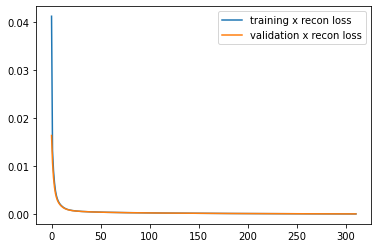

In [10]:
plt.plot(np.arange(epochs),train_loss_x_ep)
plt.plot(np.arange(epochs),val_loss_ep)
plt.legend(['training x recon loss','validation x recon loss'],loc='upper right')
plt.savefig(os.path.join(plotsavepath,'loss_seed3_x.jpg'))
plt.show()


In [11]:
#test loss
with torch.no_grad():
    modelcnn.cuda()
    modelcnn.eval()
    loss_test_all=0
    ntestBatches=int(np.ceil(testIdx.shape[0]/batchsize))
    for i in range(ntestBatches):
        testIdx_i=testIdx[i*batchsize:min((i+1)*batchsize,testIdx.shape[0])]
        testInput=torch.tensor(allImg[testIdx_i])
        if use_cuda:
            testInput=testInput.cuda().float()
        recon,z, mu, logvar = modelcnn(testInput)

        loss_test=loss_x(recon, testInput).item()

        loss_test_all+=loss_test

    loss_test_all=loss_test_all/ntestBatches
print(loss_test_all)

0.00011390979794199549


0


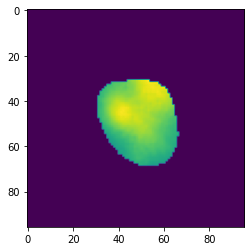

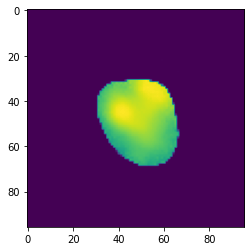

1


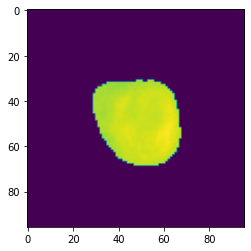

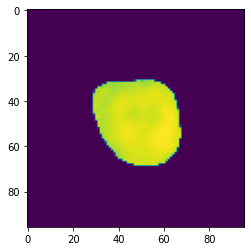

2


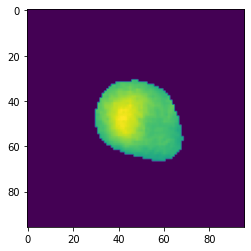

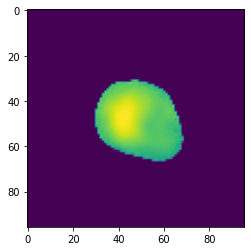

3


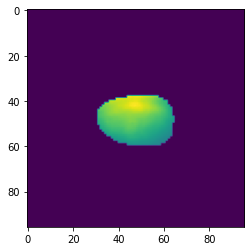

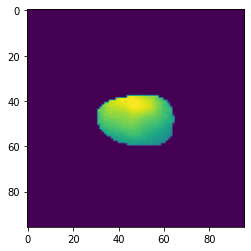

4


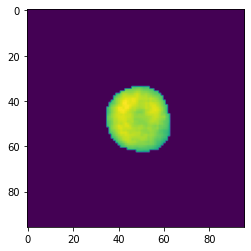

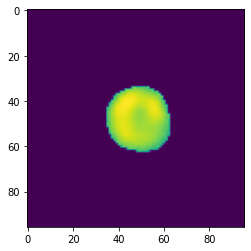

5


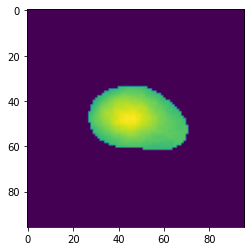

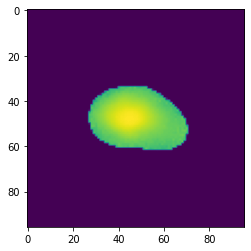

6


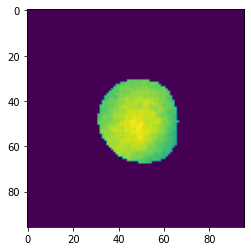

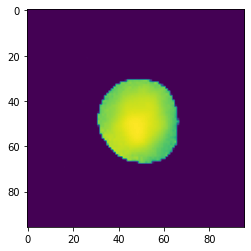

7


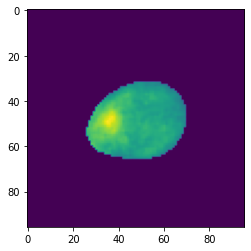

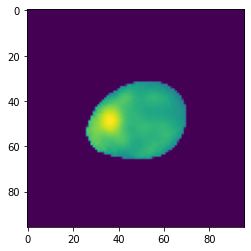

8


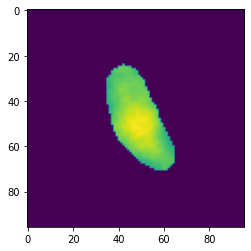

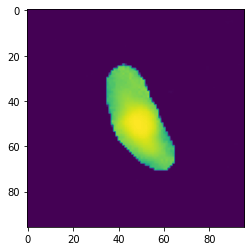

9


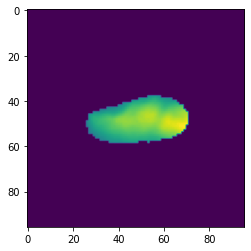

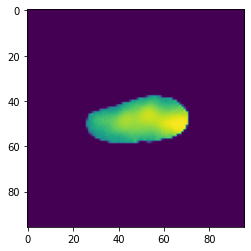

In [12]:
with torch.no_grad():
    testIdx_i=np.array([ 946042,  268296, 1680734,  610892, 1732454,   41777,  820490,145414, 1635248,  697208])
    testInput=torch.tensor(allImg[testIdx_i])
    if use_cuda:
        testInput=testInput.cuda().float()
    recon,z, mu, logvar = modelcnn(testInput)
    for i in range(10):
        print(i)
        plt.imshow(testInput[i][0].cpu().detach().numpy())
        plt.show()
        plt.imshow(recon[i][0].cpu().detach().numpy())
        plt.show()

In [7]:
#compute latent
ep=311
use_cuda=True
modelcnn.load_state_dict(torch.load(os.path.join(modelsavepath,str(ep)+'.pt')))
latent=np.zeros((allImg.shape[0],fc_dim2))
with torch.no_grad():
    modelcnn.cuda()
    modelcnn.eval()
    nplotBatches=int(np.ceil(allImg.shape[0]/batchsize))
    for i in range(nplotBatches):
        plotInput=torch.tensor(allImg[i*batchsize:min((i+1)*batchsize,allImg.shape[0])])
        if use_cuda:
            plotInput=plotInput.cuda().float()
        recon,z, mu, logvar = modelcnn(plotInput)
        latent[i*batchsize:min((i+1)*batchsize,allImg.shape[0])]=z.cpu().detach().numpy()


In [8]:
import umap
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans

np.random.seed(seed)
def plotembeddingbyCT(ctlist,savename,excludelist,embedding,savepath,plotname,plotdimx=0,plotdimy=1,savenameAdd='',img=None,ncolors=None):
    
    celltypes=np.unique(ctlist)
    if ncolors is None:
        colortest=sns.color_palette("husl", celltypes.size)
    else:
        colortest=sns.color_palette("husl", ncolors)
    fig, ax = plt.subplots(dpi=400)
    if not img is None:
        plt.imshow(img)
    for ct in celltypes:
        if ct in excludelist:
            continue
        idx=(ctlist==ct)
        if not img is None:
            ax.scatter(
                embedding[idx, plotdimy],
                embedding[idx, plotdimx],
#                 color=colortest[celltypes_dict[ct]],label=ct,s=1.5,alpha=0.5
                color=colortest[int(ct)],label=ct,s=1.5,alpha=0.5
                )
        else:
            ax.scatter(
                embedding[idx, plotdimx],
                embedding[idx, plotdimy],
#                 color=colortest[celltypes_dict[ct]],label=ct,s=1.5,alpha=0.5
                color=colortest[int(ct)],label=ct,s=2.5,alpha=1
                )

    plt.gca().set_aspect('equal', 'datalim')
    fig.set_figheight(5)
    fig.set_figwidth(5)
    box = ax.get_position()
    ax.set_position([box.x0, box.y0 + box.height * 0.1,
                     box.width, box.height * 0.9])
    # Put a legend below current axis
#     ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
#               fancybox=True, shadow=True, ncol=2,prop={'size': 6})
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
              fancybox=True,ncol=5, shadow=True,prop={'size': 6})
#     ax.legend(ncol=3)
    plt.title(plotname+' embedding', fontsize=12)
    plt.savefig(os.path.join(savepath,savename+savenameAdd+'.jpg'))
#     plt.show()
    
#     fig.clf()
    plt.close('all')
    
    gc.collect()
    
def plotembeddingbyCT_str(ctlist,savename,excludelist,embedding,savepath,plotname,plotdimx=0,plotdimy=1,savenameAdd=''):
    celltypes=np.unique(ctlist)
    celltypes_dict={}
    idx=0
    for ct in celltypes:
        celltypes_dict[ct]=idx
        idx+=1
        
    colortest=sns.color_palette("husl", celltypes.size)
#     colortest=sns.color_palette("husl", 4)
#     np.random.shuffle(colortest)
    fig, ax = plt.subplots(dpi=400)
    for ct in celltypes:
        if ct in excludelist:
            continue
        idx=(ctlist==ct)
        ax.scatter(
            embedding[idx, plotdimx],
            embedding[idx, plotdimy],
            color=colortest[celltypes_dict[ct]],label=ct,s=1.5,alpha=0.5
#             color=colortest[int(ct)],label=ct,s=1.5,alpha=0.5
            )

    plt.gca().set_aspect('equal', 'datalim')
    fig.set_figheight(5)
    fig.set_figwidth(5)
    box = ax.get_position()
    ax.set_position([box.x0, box.y0 + box.height * 0.1,
                     box.width, box.height * 0.9])
    # Put a legend below current axis
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
              fancybox=True,ncol=2, shadow=True,prop={'size': 6})
#     ax.legend(ncol=3)
    plt.title(plotname+' embedding', fontsize=24)
#     plt.tight_layout()
    plt.savefig(os.path.join(savepath,savename+savenameAdd+'.jpg'))
#     plt.show()
    
#     fig.clf()
    plt.close('all')
    
    gc.collect()
    
np.random.seed(seed)
def plotembeddingbyCT_contrast(ctlist,savename,excludelist,embedding,savepath,plotname,plotdimx=0,plotdimy=1,savenameAdd='',maxplot=None): 
    celltypes=np.unique(ctlist)
    celltypes_dict={}
    idx=0
    for ct in celltypes:
        celltypes_dict[ct]=idx
        idx+=1

    colortest=sns.color_palette("tab10")
    if not os.path.exists(os.path.join(savepath)):
        os.makedirs(savepath)

    for ct in celltypes:
        if maxplot and int(ct)>maxplot:
            continue
        fig, ax = plt.subplots()
        if ct == 'Unassigned':
            continue

        idx=(ctlist!=ct)
        ax.scatter(
            embedding[idx, plotdimx],
            embedding[idx, plotdimy],
            color=colortest[1],label='others',s=1,alpha=0.5
            )

        idx=(ctlist==ct)
        ax.scatter(
            embedding[idx, plotdimx],
            embedding[idx, plotdimy],
            color=colortest[0],label=ct,s=3,alpha=0.5
            )

        plt.gca().set_aspect('equal', 'datalim')
        fig.set_figheight(10)
        fig.set_figwidth(10)
        ax.legend()
#         plt.title(plotname+' embedding', fontsize=24)
        plt.gcf().savefig(os.path.join(savepath,savename+'_'+str(ct)+savenameAdd+'.jpg'))
#         plt.show()
#         nplot+=1
        
    
#         fig.clf()
        plt.close('all')
        gc.collect()

In [9]:
with open(os.path.join(datadir,'processed','train_cnnvae_names'), 'rb') as input:
    allImgNames=pickle.load(input)
    
n_neighbors=10
min_dist=0.25

savenameAdd='_nn'+str(n_neighbors)+'mdist0'+str(int(min_dist*100))+'epoch'+str(ep)

plottype='umap'
sampledir=plotsavepath
savedir=os.path.join(sampledir,'embedding_'+plottype)
clustersavedir=os.path.join(sampledir,'cluster')
if not os.path.exists(sampledir):
    os.mkdir(sampledir)
if not os.path.exists(savedir):
    os.mkdir(savedir)
if not os.path.exists(clustersavedir):
    os.mkdir(clustersavedir)
    
#plot by disease progression
br1003aSpecs=pd.read_excel('/media/xinyi/dcis2idc1/data/BR1003a specs.xlsx',header=10)
br301Specs=pd.read_excel('/media/xinyi/dcis2idc1/data/BR301 specs.xlsx',header=10)
br8018aSpecs=pd.read_excel('/media/xinyi/dcis2idc1/data/BR8018a specs.xlsx',header=10)
br1003aSpecs.index=br1003aSpecs.loc[:,'Position']
br301Specs.index=br301Specs.loc[:,'Position']
br8018aSpecs.index=br8018aSpecs.loc[:,'Position']

progList=np.copy(allImgNames)
for s in np.unique(allImgNames):
    ssplit=s.split('_')
    if 'br1003a'==ssplit[0]:
        prog_s=br1003aSpecs.loc[(ssplit[-1],'Pathology diagnosis')]
    elif 'br301'==ssplit[0]:
        prog_s=br301Specs.loc[(ssplit[-1],'Pathology diagnosis')]
    elif 'br8018a'==ssplit[0]:
        prog_s=br8018aSpecs.loc[(ssplit[-1],'Pathology diagnosis')]
    progList[allImgNames==s]=prog_s
    


In [10]:
plotepoch=str(ep)
def clusterMinibatchKmean_single(inArray,ncluster,n_pcs,batchsize=400):
    n_pcs=np.min([inArray.shape[0]-1,inArray.shape[1]-1,n_pcs])
    batchsize=int(np.min([(inArray.shape[0]-1)/3,(inArray.shape[1]-1)/3,batchsize]))
    
    kmeansestimator= MiniBatchKMeans(n_clusters=ncluster,random_state=seed,batch_size=batchsize).fit(inArray[:,:n_pcs])
    return kmeansestimator

def clusterMinibatchKmean_allsample(savedir,clustersavedir,inArray,nclusterL,n_pcs,sobj_coord_np,samplenameList,savenameAdd='',plotOnly=False,plotUpdate=True,clusterOnly=False,embeddingSub=None):
    if not plotOnly:
        pca=PCA(copy=True) 
        pca=pca.fit(inArray)
        inArray=pca.transform(inArray)
        savenamepca='pca_epoch'+str(plotepoch)+savenameAdd
        with open(os.path.join(clustersavedir,savenamepca), 'wb') as output:
            pickle.dump(pca, output, pickle.HIGHEST_PROTOCOL)
    
    inertiaList=np.zeros(len(nclusterL))
    for nclusterIdx in range(len(nclusterL)):
        ncluster=nclusterL[nclusterIdx]
        gc.collect()
        print(ncluster)
        savenamecluster='minibatchkmean_ncluster'+str(ncluster)+'n_pcs'+str(n_pcs)+'epoch'+str(plotepoch)+savenameAdd
        if plotOnly and os.path.exists(os.path.join(clustersavedir,savenamecluster)):
            with open(os.path.join(clustersavedir,savenamecluster), 'rb') as output:
                clusterRes=pickle.load(output)
        else:
            kmeansestimator=clusterMinibatchKmean_single(inArray,ncluster,n_pcs)
            clusterRes=kmeansestimator.labels_
            savenamecluster='minibatchkmean_ncluster'+str(ncluster)+'n_pcs'+str(n_pcs)+'epoch'+str(plotepoch)+savenameAdd
            with open(os.path.join(clustersavedir,savenamecluster), 'wb') as output:
                pickle.dump(kmeansestimator.labels_, output, pickle.HIGHEST_PROTOCOL)
            with open(os.path.join(clustersavedir,savenamecluster+'_estimator'), 'wb') as output:
                pickle.dump(kmeansestimator, output, pickle.HIGHEST_PROTOCOL)
            if embeddingSub is None:
                plotembeddingbyCT(clusterRes,'minibatchkmean',[],embedding,savedir,plottype+' of all samples',savenameAdd=savenamecluster)
                plotembeddingbyCT_contrast(clusterRes,'minibatchkmean',[],embedding,os.path.join(savedir,'contrast'),plottype+' of all samples',savenameAdd=savenamecluster,maxplot=50)
            else:
                plotembeddingbyCT(clusterRes,'minibatchkmean',[],embeddingSub,savedir,plottype+' of all samples',savenameAdd=savenamecluster)
                plotembeddingbyCT_contrast(clusterRes,'minibatchkmean',[],embeddingSub,os.path.join(savedir,'contrast'),plottype+' of all samples',savenameAdd=savenamecluster,maxplot=50)

        
        if not plotOnly:
            inertiaList[nclusterIdx]=kmeansestimator.inertia_
            
    if not plotOnly:
        plt.plot(nclusterL, inertiaList, 'bx-')
        plt.xlabel('Values of K')
        plt.ylabel('Inertia')
        plt.savefig(os.path.join(savedir,'minibatchkmean'+savenamecluster+'_elbow.jpg'))
        plt.close()
         

In [11]:
progNames,progCounts=np.unique(progList,return_counts=True)
progSampleRate={}
for p in range(progNames.size):
    progSampleRate[progNames[p]]=np.min(progCounts)/progCounts[p]

In [12]:
np.random.seed(6)
# plotPCT=4500
plottingIdx_i=np.array([])
n_pcs=50
uniqueImgNames,imgNameIdx=np.unique(allImgNames,return_index=True)
for i in range(1):
    for sidx in range(uniqueImgNames.size):
        s=uniqueImgNames[sidx]
        p=progList[imgNameIdx[sidx]]
        print(s+' '+p)
        nsamples=int(np.sum(allImgNames==s)*progSampleRate[p])
        plottingIdx_i=np.concatenate((plottingIdx_i,
                                    np.random.choice(np.arange(allImgNames.shape[0])[allImgNames==s],nsamples,replace=False)))
    
    np.random.seed(6)
    n_neighbors=10
    min_dist=0.25
    reducer = umap.UMAP(n_neighbors=n_neighbors,min_dist=min_dist,random_state=seed).fit(latent[plottingIdx_i.astype(int)])
    savenameAdd='_nn'+str(n_neighbors)+'mdist0'+str(int(min_dist*100))+'epoch'+str(ep)

    with open(os.path.join(modelsavepath,'umap_plottingIdx_progBalanced_'+str(i)+savenameAdd), 'wb') as output:
        pickle.dump(reducer, output, pickle.HIGHEST_PROTOCOL)
        
    embedding=reducer.embedding_    
    clusterMinibatchKmean_allsample(savedir,clustersavedir,latent[plottingIdx_i.astype(int)],[8],n_pcs,None,allImgNames[plottingIdx_i.astype(int)],'_plottingIdx_progBalanced_'+str(i))
    gc.collect()

br1003a_1_cytokeratin_555_aSMA_647_hoechst_A1 Hyperplasia
br1003a_1_cytokeratin_555_aSMA_647_hoechst_A2 Hyperplasia
br1003a_1_cytokeratin_555_aSMA_647_hoechst_A4 Hyperplasia
br1003a_1_cytokeratin_555_aSMA_647_hoechst_A5 Hyperplasia
br1003a_1_cytokeratin_555_aSMA_647_hoechst_A6 Hyperplasia
br1003a_1_cytokeratin_555_aSMA_647_hoechst_A7 Hyperplasia
br1003a_1_cytokeratin_555_aSMA_647_hoechst_A8 Hyperplasia
br1003a_1_cytokeratin_555_aSMA_647_hoechst_A9 Hyperplasia
br1003a_1_cytokeratin_555_aSMA_647_hoechst_C1 Atypical hyperplasia
br1003a_1_cytokeratin_555_aSMA_647_hoechst_C10 Hyperplasia
br1003a_1_cytokeratin_555_aSMA_647_hoechst_C2 Hyperplasia
br1003a_1_cytokeratin_555_aSMA_647_hoechst_C3 Atypical hyperplasia
br1003a_1_cytokeratin_555_aSMA_647_hoechst_C4 Atypical hyperplasia
br1003a_1_cytokeratin_555_aSMA_647_hoechst_C5 Atypical hyperplasia
br1003a_1_cytokeratin_555_aSMA_647_hoechst_C6 Atypical hyperplasia
br1003a_1_cytokeratin_555_aSMA_647_hoechst_C7 Hyperplasia
br1003a_1_cytokeratin_555_

br301_6_collagen1_647_hoechst_D2 Ductal carcinoma in situ with early infiltratio
br301_6_collagen1_647_hoechst_D3 Invasive ductal carcinoma and breast tissue
br301_6_collagen1_647_hoechst_D4 Invasive ductal carcinoma
br301_6_collagen1_647_hoechst_D5 Ductal carcinoma in situ with early infiltratio
br301_6_collagen1_647_hoechst_D6 Ductal carcinoma in situ with early infiltratio
br301_6_collagen1_647_hoechst_E1 Ductal carcinoma in situ with early infiltratio
br301_6_collagen1_647_hoechst_E2 Ductal carcinoma in situ with early infiltratio
br301_6_collagen1_647_hoechst_E3 Invasive ductal carcinoma and breast tissue
br301_6_collagen1_647_hoechst_E4 Invasive ductal carcinoma
br301_6_collagen1_647_hoechst_E5 Ductal carcinoma in situ with early infiltratio
br301_6_collagen1_647_hoechst_E6 Ductal carcinoma in situ with early infiltratio
br8018a_1_cytokeratin_555_aSMA_647_hoechst_A1 Invasive ductal carcinoma
br8018a_1_cytokeratin_555_aSMA_647_hoechst_A10 Invasive ductal carcinoma
br8018a_1_cytoke

In [13]:
def plotCTcomp_hist(labels,ctlist,savepath,savenamecluster,byCT,addname=''):
    res=np.zeros((np.unique(labels).size,np.unique(ctlist).size))
    for li in range(res.shape[0]):
        l=np.unique(labels)[li]
        nl=np.sum(labels==l)
        ctlist_l=ctlist[labels==l]
        for ci in range(res.shape[1]):
            c=np.unique(ctlist)[ci]
            res[li,ci]=np.sum(ctlist_l==c)
#             res[li,ci]=np.sum(ctlist_l==c)/nl
    if not byCT:
        addname+=''
        for li in range(res.shape[0]):
            l=np.unique(labels)[li]
            nl=np.sum(labels==l)
            res[li]=res[li]/nl
    else:
        addname+='_normbyCT'
        for ci in range(res.shape[1]):
            c=np.unique(ctlist)[ci]
            nc=np.sum(ctlist==c)
            res[:,ci]=res[:,ci]/nc
    
    fig, ax = plt.subplots(nrows=res.shape[0], ncols=1,figsize=(10, 10),sharex=True,sharey=True)
    for r in range(res.shape[0]):
        ax[r].bar(np.arange(res.shape[1]),res[r])
        ax[r].set_xticks(np.arange(np.unique(ctlist).size))
        ax[r].set_xticklabels(np.unique(ctlist))
        ax[r].set_ylim(0,1)
        ax[r].set_ylabel(np.unique(labels)[r])
        
#         ax.set_yticks(np.arange(np.unique(labels).size))
#         ax.set_yticklabels(np.unique(labels))
#         ax.set_xticks(np.arange(np.unique(ctlist).size))
#         ax.set_xticklabels(np.unique(ctlist))
#         plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")
    fig.tight_layout()
    plt.savefig(os.path.join(savepath,savenamecluster+addname+'.jpg'))
    plt.close()

In [14]:
plotsavenameAdd='_plottingIdx_progBalanced_'+str(i)

In [15]:
import util.plot_new

In [16]:
progList_comb=np.copy(progList)
for p in np.unique(progList):
    if p=='Ductal carcinoma in situ':
        progList_comb[progList==p]='DCIS and breast tissue'
        progList[progList==p]='DCIS'
    elif p=='Ductal carcinoma in situ and breast tissue':
        progList_comb[progList==p]='DCIS and breast tissue'
        progList[progList==p]='DCIS and breast tissue'
    elif p=='Ductal carcinoma in situ with early infiltratio':
        progList_comb[progList==p]='DCIS with early infiltration'
        progList[progList==p]='DCIS with early infiltration'
    elif p=='Micropapillary type ductal carcinoma in situ wi':
        progList_comb[progList==p]='DCIS with early infiltration'
        progList[progList==p]='Micropapillary DCIS with early infiltration'
    elif p=='Atypical hyperlasia':
        progList_comb[progList==p]='Hyperplasia'

In [17]:
ctorder=np.array(['Breast tissue','Cancer adjacent normal breast tissue','Invasive ductal carcinoma (breast tissue)','Hyperplasia','Atypical hyperplasia','DCIS and breast tissue','DCIS','DCIS with early infiltration', 'Micropapillary DCIS with early infiltration','Invasive ductal carcinoma and breast tissue','Invasive ductal carcinoma'])
nclusterL=[8]
for ncluster in nclusterL:
    savenamecluster='minibatchkmean_ncluster'+str(ncluster)+'n_pcs'+str(n_pcs)+'epoch'+str(plotepoch)+plotsavenameAdd
    with open(os.path.join(clustersavedir,savenamecluster), 'rb') as output:
        clusterRes=pickle.load(output)
    clusterplotsavepath=os.path.join(clustersavedir,savenamecluster+'_plots')
    if not os.path.exists(clusterplotsavepath):
        os.mkdir(clusterplotsavepath)
    util.plot_new.plotCTcomp(clusterRes,progList[plottingIdx_i.astype(int)],clusterplotsavepath,'pathologyHeatmap_rename',False,ctorder=ctorder,vmin=0)
    util.plot_new.plotCTcomp(clusterRes,progList[plottingIdx_i.astype(int)],clusterplotsavepath,'pathologyHeatmap_rename',True,ctorder=ctorder,vmin=0)

In [18]:
neworder=[5,1,0,4,3,2,7,6]
clusterRes_reordered=np.zeros_like(clusterRes)
for c in range(ncluster):
    cold=neworder[c]
    clusterRes_reordered[clusterRes==cold]=c


In [19]:
for ncluster in nclusterL:
    savenamecluster='minibatchkmean_ncluster'+str(ncluster)+'n_pcs'+str(n_pcs)+'epoch'+str(plotepoch)+plotsavenameAdd
    clusterplotsavepath=os.path.join(clustersavedir,savenamecluster+'_plots')
    util.plot_new.plotCTcomp(clusterRes_reordered,progList[plottingIdx_i.astype(int)],clusterplotsavepath,'pathologyHeatmap_rename_reordered',False,ctorder=ctorder,vmin=0)
    util.plot_new.plotCTcomp(clusterRes_reordered,progList[plottingIdx_i.astype(int)],clusterplotsavepath,'pathologyHeatmap_rename_reordered',True,ctorder=ctorder,vmin=0)

In [20]:
refDir=os.path.join('/media/xinyi/dcis2idc1/plots/cnnvaeexp0','cluster')
savenamecluster='minibatchkmean_ncluster'+str(ncluster)+'n_pcs'+str(n_pcs)+'epoch'+str(plotepoch)+'_plottingIdx_progBalanced_'+str(i)+'_reordered'
with open(os.path.join(refDir,savenamecluster), 'rb') as output:
    clusterRes_ref=pickle.load(output)

In [21]:
util.plot_new.plotCTcomp(clusterRes_reordered,clusterRes_ref,clusterplotsavepath,'compareToOriginal',False,vmin=0)
